# BEWARE!
need to run this notebook one folder down from lsst package install

In [1]:
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import sncosmo

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic

In [3]:
%matplotlib notebook

In [4]:
default_cosmology = cosmo

def random_ra_dec(size=None):
    if size == None:
        use_size = 1
    else:
        use_size = size
    
    p, q = np.random.random((2, use_size))

    ra = 360. * p
    dec = np.arcsin(2. * (q - 0.5)) * 180 / np.pi

    if size == None:
        return ra[0], dec[0]
    else:
        return ra, dec

class SourceDistribution():
    def count(self, time):
        pass

    def simulate(self, count, start_time, end_time, flat_redshift=False):
        pass

class VolumetricSourceDistribution(SourceDistribution):
    """Model sources that are equally distributed across the sky.

    Parameters
    ----------
    volumetric_rate : float or function
        The volumetric rate in counts/yr/Mpc**3. This can be either a float
        representing a constant rate as a function of redshift
        or a function that takes the redshift as a parameter and returns the
        volumetric rate at that redshift.
    """
    def __init__(self, volumetric_rate, min_redshift=0., max_redshift=3.,
                 cosmology=default_cosmology):
        self.volumetric_rate = volumetric_rate
        self.cosmology = cosmology

        self._update_redshift_distribution(min_redshift, max_redshift)

    def _update_redshift_distribution(self, min_redshift, max_redshift, redshift_bins=10000):
        """Set up the distribution to operate over a given redshift range.

        This also creates and inverse CDF sampler to draw redshifts from.
        """
        self.min_redshift = min_redshift
        self.max_redshift = max_redshift

        sample_redshift_range = np.linspace(
            min_redshift, max_redshift, redshift_bins
        )
        normalized_rates = self.rate(sample_redshift_range)
        normalized_rates /= np.sum(normalized_rates)
        cum_rates = np.cumsum(normalized_rates)

        self.redshift_cdf = interpolate.interp1d(
            cum_rates,
            sample_redshift_range
        )

    def rate(self, redshift):
        """Calculate the total rate of this source at a given redshift.
        
        Parameters
        ----------
        redshift : float
            The redshift to estimate the rate at.
            
        Returns
        -------
        rate : float
            The rate of this source at the given redshift in counts/yr/unit redshift"""
        if callable(self.volumetric_rate):
            rate = self.volumetric_rate(redshift)
        else:
            rate = self.volumetric_rate

        rate = rate * self.cosmology.differential_comoving_volume(redshift).value * 4 * np.pi

        return rate

    def count(self, time):
        """Count how many transients we would expect to see in a given time.

        Parameters
        ----------
        time : float
            The time in years.
        """
        return integrate.quad(self.rate, self.min_redshift, self.max_redshift)[0] * time

    def simulate(self, count, start_time, end_time, flat_redshift=False):
        """Simulate transients"""
        ref_count = self.count((end_time - start_time) * 365.2425)

        if flat_redshift:
            # Sample from a flat redshift distribution
            redshifts = np.random.uniform(self.min_redshift, self.max_redshift, count)
            weights = self.rate(redshifts) / count
        else:
            # Sample from the True redshift distribution
            redshifts = self.redshift_cdf(np.random.random(size=count))
            weights = np.ones(len(redshifts))
            
        ras, decs = random_ra_dec(count)

        result = Table(
            [redshifts, ras, decs, weights],
            names=['z', 'ra', 'dec', 'weight'],
        )

        return result
    
class SALT2Distribution(VolumetricSourceDistribution):
    def simulate(self, count, start_time, end_time, *args, **kwargs):
        result = super().simulate(count, start_time, end_time, *args, **kwargs)

        result['source'] = 'salt2-extended'
        result['params'] = [('z', 't0', 'x1', 'c')]
        
        result['t0'] = np.random.uniform(start_time, end_time, count)
        result['x1'] = np.random.normal(0, 1, count)
        result['c'] = np.random.exponential(0.1, count)

        result['peakabsmag'] = -19.1 - 0.13 * result['x1'] + 3.1 * result['c']
        result['peakmagband'] = 'bessellb'
        result['peakmagsys'] = 'ab'

        return result
    
def generate_model(meta):
    model = sncosmo.Model(source=meta['source'])

    for param in meta['params']:
        model[param] = meta[param]

    model.set_source_peakabsmag(meta['peakabsmag'], meta['peakmagband'], meta['peakmagsys'])

    return model

In [5]:
# simulate survey
# init
base_mjd = 59580.
survey_length = 10. * 365.

# volumetric rate of Ias
volumetric_rate = lambda z: 2.6e-5*(1+z)**1.5
# simulate Ias light-curves parameters in these footprint
d = SALT2Distribution(volumetric_rate, 0.0, 0.8)

sim = d.simulate(10000, base_mjd, base_mjd + survey_length, flat_redshift=True)

In [6]:
# sim outputs SNe Ia light-curve parameters
sim.keys()

['z',
 'ra',
 'dec',
 'weight',
 'source',
 'params',
 't0',
 'x1',
 'c',
 'peakabsmag',
 'peakmagband',
 'peakmagsys']

In [7]:
# Set up the slicer to evaluate the catalog we just made
slicer = slicers.UserPointsSlicer(sim['ra'], sim['dec'], latLonDeg=True, badval=0)

for key in sim.keys():
    if key not in ['ra', 'dec']:
        slicer.slicePoints[key] = sim[key]

# Observing strategy
Generate light-curves for this observing cadence

In [8]:
# Load observing strategy used for this experiment
#This next command assumes you have downloaded a database into this directory
opsdb = db.OpsimDatabase('/Users/anaismoller/Science/LSST/observing_strategy/cadence/kraken_2026.db')
# Init of this experiment
runName = 'test_sncosmo'
outDir = 'test_sim_sncosmo'
resultsDb = db.ResultsDb(outDir=outDir)

In [9]:
class SNCosmoDetectabilityMetric(metrics.BaseMetric):
    """
    Quantifies detectability of sncosmo objects.

    Parameters
    ----------
    ptsNeeded : int
        Number of an object's lightcurve points required to be above the 5-sigma limiting depth 
        before it is considered detected.

    Notes
    -----
    TODO: Update this
    
    This metric assumes this will be run with a slicer that has had extra 
    parameters (t0, peak, and slope) added to the slicer.slicePoint 
    dict (which already contains ra, dec, fieldID, etc). All the observation information 
    (MJD of observation, 5-sigma limiting depth of each observation, etc) is contained in the
    dataSlice array. We request the filter information for each observation anticipating that
    more general lightcurve functions will need it as input.
    """
    def __init__(self, metricName='TestSNMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', ptsNeeded=2, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.ptsNeeded = ptsNeeded

        super().__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                         units='fraction',
                         metricName=metricName,
                         **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        model = generate_model(slicePoint)
        bands = np.array([f'lsst{i}' for i in dataSlice[self.filterCol]])
        fluxes = model.bandflux(bands, dataSlice[self.mjdCol], zp=25., zpsys='ab')
        fluxerrs = 10**(-0.4*(dataSlice[self.m5Col] - 25)) / 5.

        metric_val = {}
        
        npts = np.sum(fluxes > fluxerrs * 5.)
        if npts >= self.ptsNeeded:
            metric_val['detected'] = 1.
        else:
            metric_val['detected'] = 0.
        
        metric_val['model'] = model
        metric_val['mjds'] = dataSlice[self.mjdCol]
        metric_val['bands'] = bands
        metric_val['fluxes'] = fluxes
        metric_val['fluxerrs'] = fluxerrs

        return metric_val

    def reduceDetected(self, metric_val):
        return metric_val['detected']

In [10]:
metric = SNCosmoDetectabilityMetric()
#sql = 'night < %i and (filter="r" or filter="i" or filter="z")' % (365.25*5)
sql = ''

summary_stats = [metrics.MeanMetric(maskVal=0)]

plotFuncs = [plots.HealpixSkyMap()]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName, summaryMetrics=summary_stats, plotFuncs=plotFuncs)

In [11]:
%%time

bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with no constraint for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec'].
Found 2438388 visits
Running:  ['test_sncosmo_TestSNMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 45.5 s, sys: 5.13 s, total: 50.7 s
Wall time: 50.8 s


Plotting figures with "" constraint now.


/Users/anaismoller/Science/Programs/lsst/stack/miniconda3-4.7.12-984c9f7/DarwinX86/sims_maf/2.13.0.sims-25-g51cea12b+1/python/lsst/sims/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


<IPython.core.display.Javascript object>


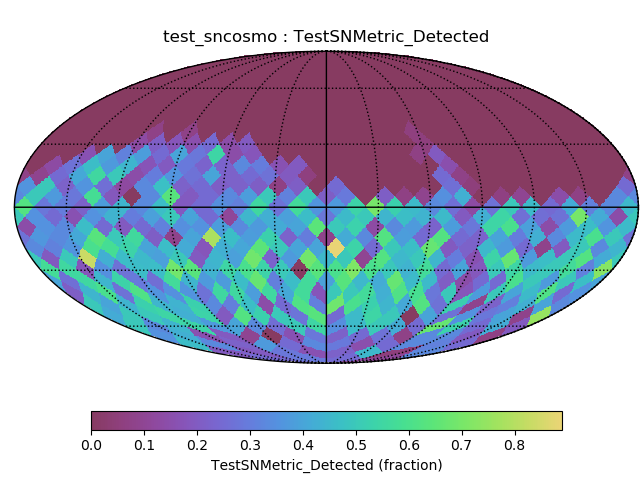

Plotting complete.


In [12]:
bgroup.plotAll(closefigs=False)

<IPython.core.display.Javascript object>


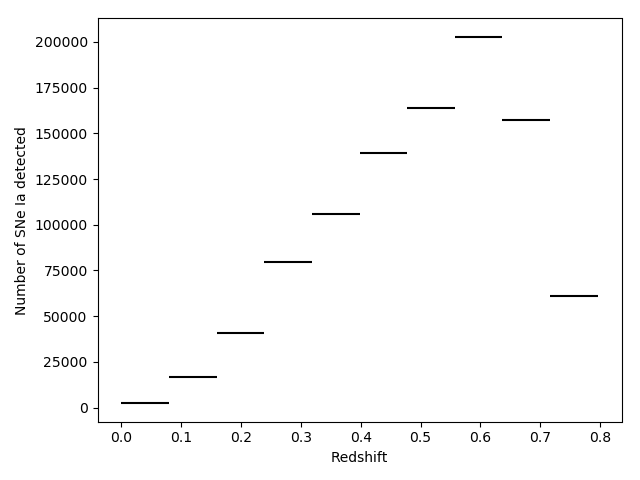

In [13]:
# Total number of supernovae detected for each redshift
from scipy.stats import binned_statistic

mask = ~bundle.metricValues.mask
detected = np.array([i['detected'] for i in bundle.metricValues[mask]], dtype=bool)
mask_sim = sim[mask][detected]

bin_stat, bin_edges, binnumber = binned_statistic(mask_sim['z'], mask_sim['weight'], statistic='sum')
bin_widths = bin_edges[1:] - bin_edges[:-1]
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
plt.figure()
plt.hlines(bin_stat, bin_edges[:-1], bin_edges[1:])

plt.xlabel('Redshift')
plt.ylabel('Number of SNe Ia detected')
plt.tight_layout()

<IPython.core.display.Javascript object>


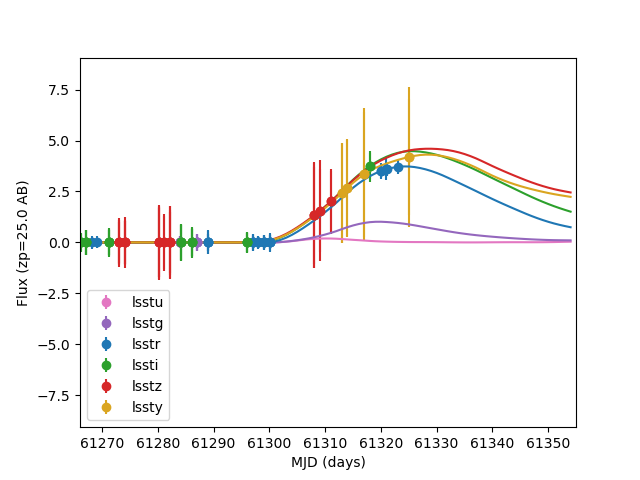

Text(0, 0.5, 'Flux (zp=25.0 AB)')

In [14]:
# Plot a light curve
idx = 100

metric_val = bundle.metricValues[idx]
if not metric_val:
    raise Exception(f"Index {idx} is masked!")

model = metric_val['model']
mjds = metric_val['mjds']
fluxes = metric_val['fluxes']
fluxerrs = metric_val['fluxerrs']
bands = np.array(metric_val['bands'])

band_plot_colors = {
    "lsstu": "C6",
    "lsstg": "C4",
    "lsstr": "C0",
    "lssti": "C2",
    "lsstz": "C3",
    "lssty": "goldenrod",
}

plt.figure()

min_mjd = np.min(mjds[fluxes > 0.001]) - 30
max_mjd = np.max(mjds[fluxes > 0.001]) + 30
plot_mjds = np.arange(min_mjd, max_mjd)

for band in band_plot_colors:
    match = bands == band
    c = band_plot_colors[band]

    plt.errorbar(mjds[match], fluxes[match], fluxerrs[match], fmt='o', c=c, label=band)

    model_flux = model.bandflux(band, plot_mjds, 25.0, 'ab')
    plt.plot(plot_mjds, model_flux, c=c)

plt.xlim(min_mjd, max_mjd)
plt.legend()
plt.xlabel('MJD (days)')
plt.ylabel('Flux (zp=25.0 AB)')

# Save generated light-curves in csv format (HEAD, PHOT)

In [15]:
import pandas as pd
import os

In [23]:
# init
# outDir = './test_sim_sncosmo/'
# os.makedirs(outDir,exist_ok=True)

In [16]:
# create pandas dataframe with info for HEAD.csv
# sim[mask].keys()
df = pd.DataFrame()
df[['SIM_REDSHIFT_CMB','RA','DECL','PEAKMJD','SIM_SALT2x1','SIM_SALT2c','SIM_PEAKMAG_b']] = sim[mask][detected][['z','ra','dec','t0','x1','c','peakabsmag']].to_pandas()
# tag the type SNIa
df['SNTYPE']=np.ones(len(df)).astype(int)*101
# create IDs
df['SNID']= df.index
df.to_csv(f"{outDir}/DAT_HEAD.csv")

In [17]:
# create pandas dataframe with info for PHOT.csv
tmp ={}
dict_data = {}
dict_keys = {'SNID':'SNID','mjds':'MJD', 'bands':'FLT', 'fluxes':'FLUXCAL', 'fluxerrs':'FLUXCALERR'}
for key in ['SNID','MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR']:
    tmp[key] = []
end = len(bundle.metricValues[~bundle.metricValues.mask][detected])
for key in ['mjds', 'bands', 'fluxes', 'fluxerrs']:
    for i in range(end):
        if key == 'mjds':
            # fill SNID
            tmp['SNID'].append(np.ones(len(bundle.metricValues[~bundle.metricValues.mask][detected][i][key]))*i)
        tmp[dict_keys[key]].append(bundle.metricValues[~bundle.metricValues.mask][detected][i][key].tolist())
    dict_data[dict_keys[key]] = np.concatenate(tmp[dict_keys[key]])
dict_data['SNID'] = np.concatenate(tmp['SNID'])

In [18]:
dict_data

{'MJD': array([63005.1909375 , 62630.18334491, 63399.99585648, ...,
        62918.05334491, 62870.19920139, 62470.31717593]),
 'FLT': array(['lssti', 'lssti', 'lssty', ..., 'lsstg', 'lsstz', 'lsstg'],
       dtype='<U5'),
 'FLUXCAL': array([0., 0., 0., ..., 0., 0., 0.]),
 'FLUXCALERR': array([0.64774847, 0.92258842, 3.2610193 , ..., 0.22637515, 1.51631006,
        0.387027  ]),
 'SNID': array([   0.,    0.,    0., ..., 2407., 2407., 2407.])}

In [19]:
# tt = np.concatenate(tmp)
df = pd.DataFrame.from_dict(dict_data)

In [28]:
phot = df[df['FLUXCAL']!=0.0]
phot['SNID'] = phot['SNID'].astype(int)
phot['FLT'] = phot['FLT'].astype(str)
# change filter naming
phot['FLT'] = phot['FLT'].apply(lambda x: 'Y' if x=='y' else x)

/Users/anaismoller/Science/Programs/lsst/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/anaismoller/Science/Programs/lsst/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
phot['FLT'] = phot['FLT'].astype(str).str.strip('lsst')

/Users/anaismoller/Science/Programs/lsst/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
phot.to_csv(f"{outDir}/DAT_PHOT.csv")